# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy import units

import lightkurve as lk
import exoplanet as xo

import theano.tensor as tt
import pymc3 as pm
import pymc3_ext as pmx

import arviz as az
import corner

# Load light curve data

In [2]:
# obj = pickle.load(open("../data/export/G304_lightcurves.pkl", "rb"))

g304_clc = lk.KeplerLightCurve.read("../data/export/G304_onlyTPFnEXBA_corrected_full.fits")

bls_period       =  4.996676292653994 # d
bls_duration     =  0.091 # d
bls_depth        =  0.0050820479726194434 
bls_transit_time =  2455468.058002121 # jd

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/lightkurve/lightcurve.py:876: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BKJD (i.e. JD - 2454833).
  warnings.warn(


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

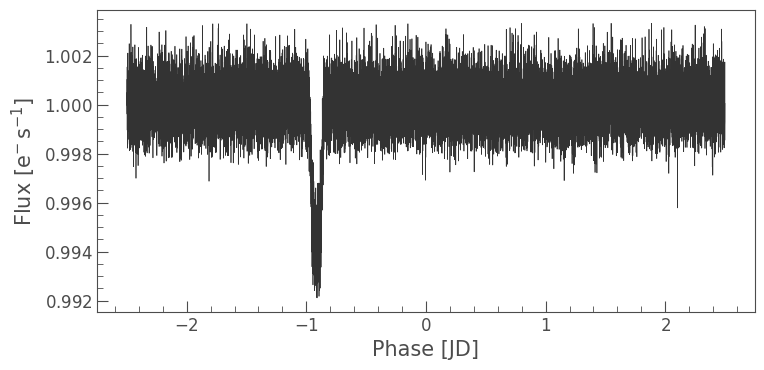

In [3]:
clean_g304_clc = g304_clc.remove_outliers(sigma_upper=3, sigma_lower=1e10)
clean_g304_clc.fold(period=bls_period, epoch_time=bls_transit_time).plot()

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
periods = np.array(bls_period)
t0s = np.array(bls_transit_time)
t = clean_g304_clc.time.jd
y = clean_g304_clc.flux.value - 1
yerr = clean_g304_clc.flux_err.value

host_radius = 0.72 * units.solRad
plnt_radius = (bls_depth ** 0.5) * host_radius
host_mass = 0.749 * units.solMass
stellar_density = 2.83 * units.gram / units.cm **3

ror = plnt_radius / host_radius
a_norm = bls_period / (np.pi * bls_duration)

In [5]:
print("Period       : ", periods, " d")
print("Transit epoch: ", t0s, " d")

print("R*           : ", host_radius)
print("Rp           : ", plnt_radius.to("Rjup"))
print("Rp / R*      : ", ror)
print("rho*         : ", stellar_density.to("kg/m3"))
print("M*           : ", host_mass)

print("a/R*         : ", a_norm)

Period       :  4.996676292653994  d
Transit epoch:  2455468.058002121  d
R*           :  0.72 solRad
Rp           :  0.4994780795812914 jupiterRad
Rp / R*      :  0.07128848415150545
rho*         :  2829.9999999999995 kg / m3
M*           :  0.749 solMass
a/R*         :  17.47792815397734


In [6]:
# stellar density from SED in kg/m3 and log10
stellar_density.to("kg/m3").value

2829.9999999999995

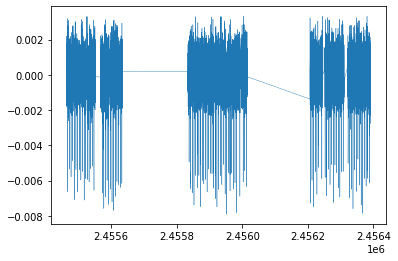

In [7]:
plt.plot(t, y, lw=0.4)

(-0.5, 0.5)

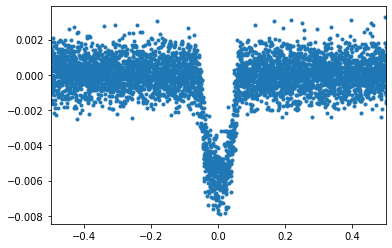

In [8]:
plt.plot((t - t0s + 0.5 * periods) % periods - 0.5 * periods, y, marker=".", lw=0)
plt.xlim(-.5,.5)

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [9]:
# M-dwarf example
rad = 0.08 * units.solRad
mass = 0.07 * units.solMass

density = (3 * mass) / (4 * np.pi * rad ** 3)
density.to("g/cm3"), density.to("kg/m3")

(<Quantity 192.74333535 g / cm3>, <Quantity 192743.33535454 kg / m3>)

In [10]:
(1 * units.kg / units.m **3).to("g/cm3"), (1e6 * units.kg / units.m **3).to("g/cm3")

(<Quantity 0.001 g / cm3>, <Quantity 1000. g / cm3>)

In [89]:
(0.5 * units.solRad).to("Rjup")

<Quantity 4.86557937 jupiterRad>

In [11]:
plnt_radius, host_radius, host_mass

(<Quantity 0.05132771 solRad>,
 <Quantity 0.72 solRad>,
 <Quantity 0.749 solMass>)

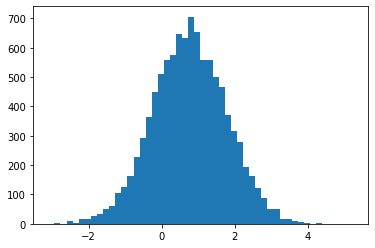

In [112]:
plt.hist(np.random.normal(host_mass.value, 1, 10000), bins=50);

In [206]:
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=.1)
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # Stellar Parameters
    # r_star
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=5)
    # r_star = BoundedNormal("r_star", mu=host_radius.value, sd=1)
    r_star = pm.Uniform("r_star", lower=0.0, upper=10, shape=1, 
                        testval=host_radius.value)
    
    # m_star = BoundedNormal("m_star", mu=host_mass.value, sd=1)
    # m_star = pm.Normal("m_star", mu=host_mass.value, sd=0.2)
    m_star = pm.Uniform("m_star", lower=0.0, upper=10, shape=1, testval=host_mass.value)
    
    # stellar density see Sandford & Kippong 2017 for prior info
    # https://iopscience.iop.org/article/10.3847/1538-3881/aa94bf/pdf
    # using log10. np.log10(rho_star in kg/m3)
    # lower lim is 0.001 g/cm3, an O5 type 
    # upper lim from M9V red dwarf with 0.07 Msun and 0.08 Rsun
    # logrho_star = pm.Uniform("logrho_star", lower=0, upper=6, shape=1, testval=3.45)
    # rho_star = pm.Deterministic("rho_star", tt.power(10, logrho_star))
    # rho_star = pm.Uniform("rho_star", lower=1e2, upper=1e4, shape=1, testval=2830)

    
    # Orbital parameters of the planet
    # The time of a reference transit for each planet
    t0 = pm.Uniform("t0", lower=t0s - 0.1, upper=t0s + 0.1, 
                    shape=1, testval=t0s)
    # t0 = pm.Normal("t0", mu=t0s, sd=0.01, shape=1)
    
    # duration = pm.Uniform("duration", lower=0.001, upper=0.5, 
    #                       shape=1, testval=bls_duration)
    # BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=0.5)
    # duration = BoundedNormal("duration", mu=bls_duration, sd=0.1)

    # The log period; also tracking the period itself
    # logP = pm.Normal("logP", mu=np.log(periods), sd=0.01, shape=1)
    # period = pm.Deterministic("period", pm.math.exp(logP))
    # period = pm.Normal("period", mu=periods, sd=0.01, shape=1)
    period = pm.Uniform("period", lower=periods * 0.95, upper=periods * 1.05, 
                        shape=1, testval=periods)

    # planet Radius
    r_pl = pm.Uniform(
        "r_pl", lower=0.001, upper=0.5, shape=1, testval=plnt_radius.value
    )
    ror = pm.Deterministic("ror", r_pl / r_star)
    
    # impact parameter of the orbit
    b = xo.distributions.ImpactParameter(
        "b", ror=ror, shape=1, testval=np.random.rand(1)
    )
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, #duration=duration,
                                     b=b, 
                                     r_star=r_star, m_star=m_star)
                                     # rho_star=rho_star, rho_star_units=(units.kg / units.m **3))
    # stellar density for cicular orbit
    pm.Deterministic("rho_circ", orbit.rho_star)
    

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r_pl, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # ******************************************************************* #
    # On the folowing lines, we simulate the dataset that we will fit     #
    #                                                                     #
    # NOTE: if you are fitting real data, you shouldn't include this line #
    #       because you already have data!                                #
    # ******************************************************************* #
    # y = pmx.eval_in_model(light_curve)
    # y += yerr * np.random.randn(len(y))
    # ******************************************************************* #
    # End of fake data creation; you want to include the following lines  #
    # ******************************************************************* #

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the dataset
    map_soln = pmx.optimize(start=model.test_point, vars=[period])
    map_soln = pmx.optimize(start=map_soln, vars=[t0])
    # map_soln = pmx.optimize(start=map_soln, vars=[duration])
    map_soln = pmx.optimize(start=map_soln, vars=[r_pl])
    map_soln = pmx.optimize(start=map_soln, vars=[b])
    map_soln = pmx.optimize(start=map_soln, vars=[u])
    map_soln = pmx.optimize(start=map_soln, vars=[r_star])
    map_soln = pmx.optimize(start=map_soln, vars=[m_star])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [period]


message: Desired error not necessarily achieved due to precision loss.
logp: 129202.16463732156 -> 129202.30260042446
optimizing logp for variables: [t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 129202.30260042446 -> 129203.38321609635
optimizing logp for variables: [r_pl]


message: Optimization terminated successfully.
logp: 129203.38321609635 -> 129314.41154591106
optimizing logp for variables: [b, r_pl, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 129314.41154591106 -> 130499.68370242398
optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: 130499.68370242398 -> 130499.81355398329
optimizing logp for variables: [r_star]


message: Optimization terminated successfully.
logp: 130499.81355398332 -> 130499.82518172894
optimizing logp for variables: [m_star]


message: Optimization terminated successfully.
logp: 130499.82518172894 -> 130499.87914803327
optimizing logp for variables: [b, r_pl, period, t0, m_star, r_star, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 130499.87914803327 -> 130570.29111330761


In [211]:
# var_names = ["r", "b", "u", "mean", "rho_star", "r_star"]
var_names = ["period", "t0", "r_pl", "b", "u", "mean", "m_star", "r_star", "rho_circ"]
# var_names = ["period", "t0", "duration", "r_pl", "b", "u", "mean", "r_star", "rho_circ"]

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

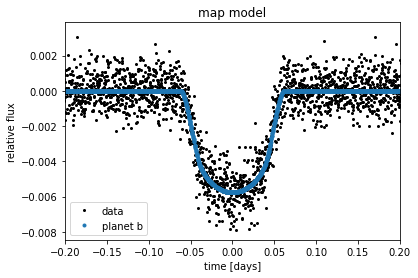

In [212]:
t_phase = (t - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln["period"] - 0.5 * map_soln["period"]
plt.plot(t_phase, y, ".k", ms=4, label="data")
plt.plot(
    t_phase, map_soln["light_curves"][:, 0], lw=0, marker='.', label="planet {0}".format("b")
)
plt.xlim(-.2, .2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use `pmx.sample` from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext).

In [214]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=2000,
        start=map_soln,
        cores=4,
        chains=4,
        initial_accept=0.8,
        target_accept=0.95,
        return_inferencedata=False
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, r_pl, period, t0, m_star, r_star, u, mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 773 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8977910011128851, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [223]:
trace.add_values({"r_jup": (trace.r_pl * units.R_sun).to(units.Rjup).value})
try:
    trace.add_values({"a/r_star": trace.period / (trace.duration * np.pi)})
except KeyError:
    trace.add_values({"a/r_star": trace.period / (bls_duration * np.pi)})

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [215]:
with model:
    summary = az.summary(
        trace, var_names=var_names
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],4.997,0.000,4.997,4.997,0.000,0.000,7313.0,5185.0,1.00
t0[0],2455468.054,0.001,2455468.053,2455468.055,0.000,0.000,6110.0,4812.0,1.00
r_pl[0],0.186,0.031,0.125,0.238,0.001,0.001,536.0,1016.0,1.01
b[0],0.799,0.023,0.755,0.842,0.000,0.000,4231.0,4629.0,1.00
u[0],0.563,0.316,0.009,1.098,0.007,0.005,1847.0,1165.0,1.00
u[1],0.283,0.374,-0.423,0.910,0.008,0.007,1874.0,1649.0,1.00
mean,0.000,0.000,0.000,0.000,0.000,0.000,6394.0,4691.0,1.00
m_star[0],6.330,2.457,2.027,10.000,0.115,0.081,421.0,604.0,1.01
r_star[0],2.388,0.387,1.582,2.967,0.018,0.013,516.0,964.0,1.01
rho_circ[0],0.620,0.080,0.480,0.773,0.001,0.001,4686.0,4456.0,1.00


/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


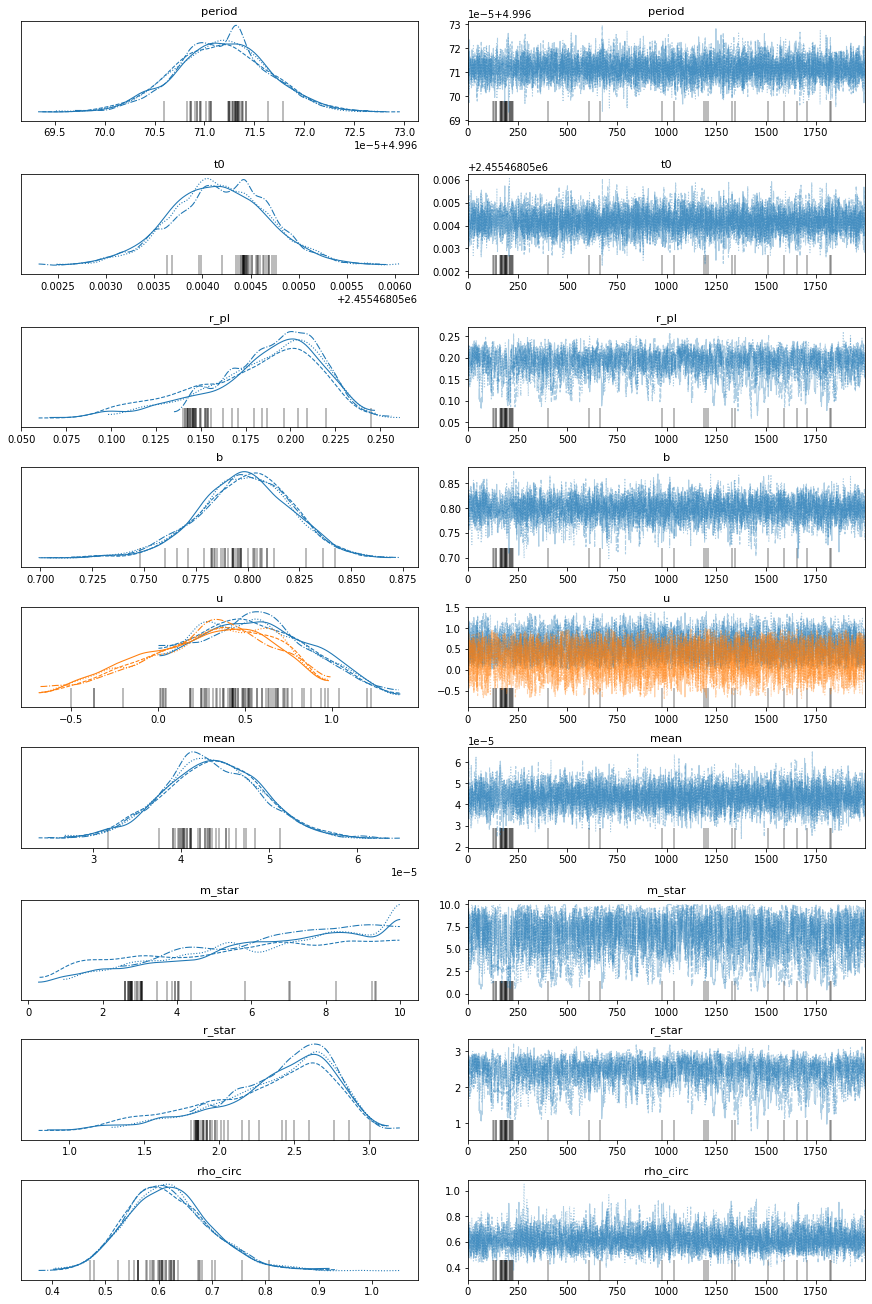

In [216]:
with model:
    az.plot_trace(trace, var_names=var_names)

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [217]:
truth

{'period': array(4.99667629),
 't0': array(2455468.05800212),
 'duration': 0.091,
 'r_jup': 0.4994780795812914,
 'b': array([0.73199394]),
 'm_star': 0.749,
 'r_star': 0.72,
 'rho_circ': 2.83,
 'a/r_star': None}

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


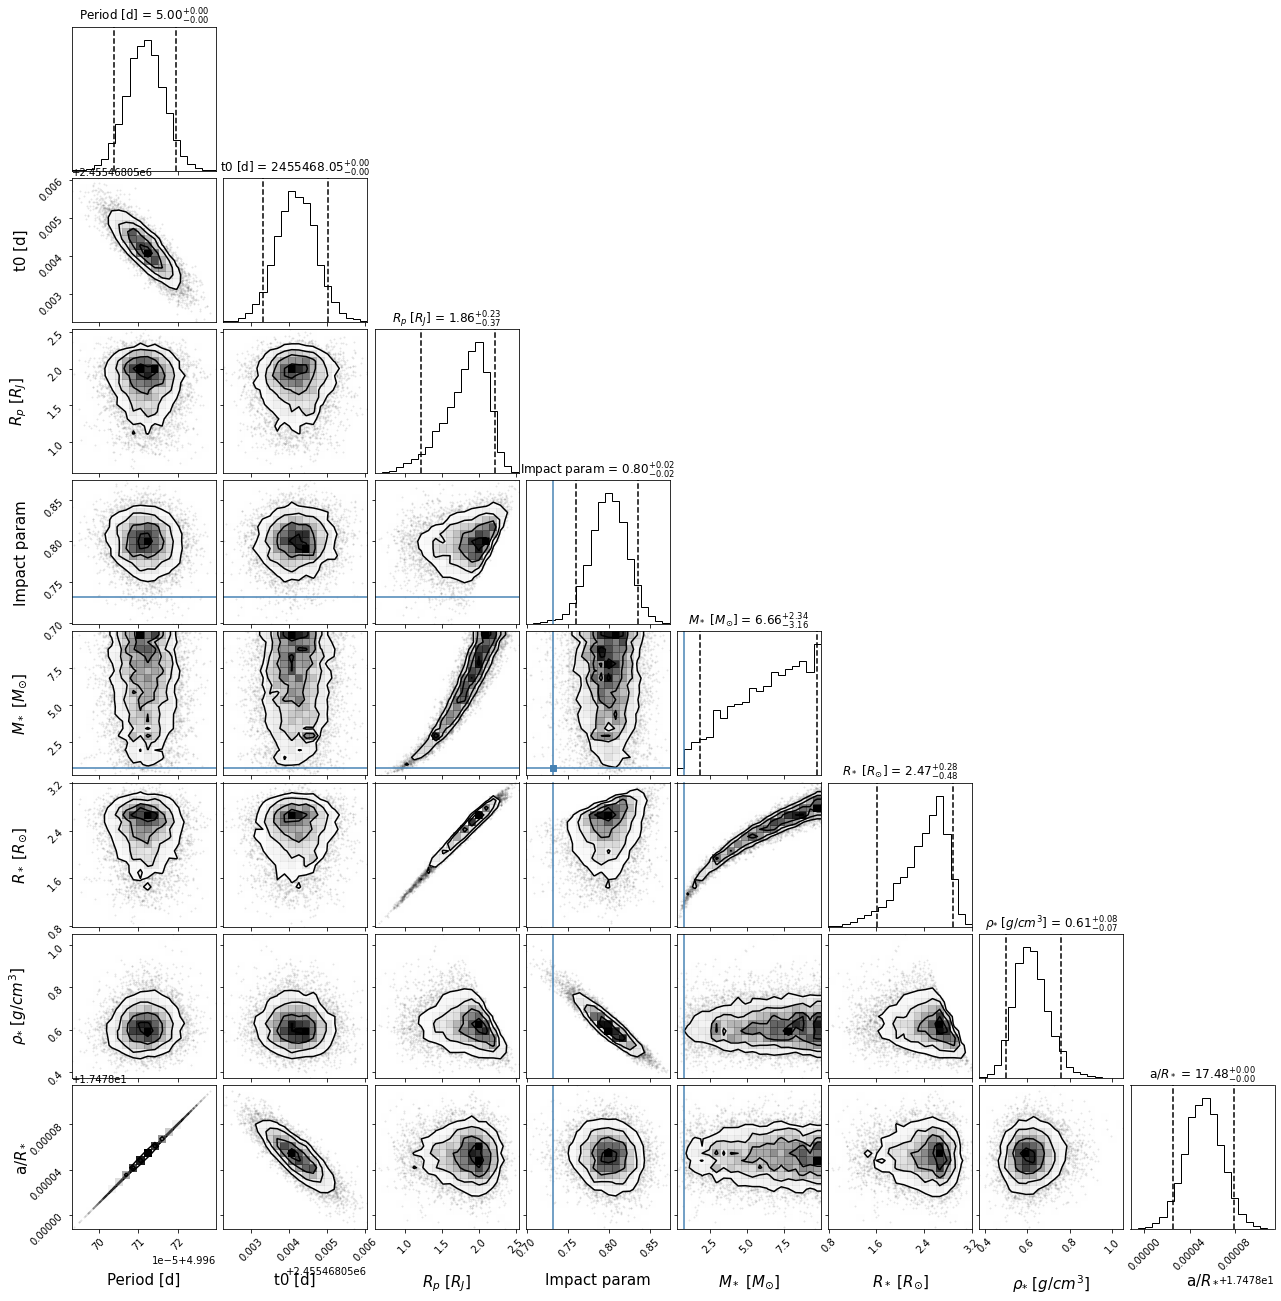

In [224]:
var_corner = ["period", 't0', "r_jup", "b", "m_star", "r_star", "rho_circ", "a/r_star"]
# var_corner = ["period", 't0', "duration", "r_jup", "b", "r_star", "rho_circ", "a/r_star"]
labels = ["Period [d]", "t0 [d]", "$R_p$ [$R_{J}$]", 
            "Impact param", "$M_*$ [$M_{\odot}$]", 
            "$R_*$ [$R_{\odot}$]", r"$\rho_{*}$ [$g/cm^3$]", "a/$R_*$"]
# labels = ["Period [d]", "t0 [d]", "Duration [d]",
#           "$R_p$ [$R_{J}$]", 
#             "Impact param", 
#             "$R_*$ [$R_{\odot}$]", r"$\rho_{*}$ [$g/cm^3$]",
#           "a/$R_*$"]
truth = {
    "period": periods,
    't0': t0s,
    "duration": bls_duration,
    "r_jup": plnt_radius.to("Rjup").value,
    "b": pmx.eval_in_model(b, model.test_point, model=model),
    "m_star": host_mass.value,
    "r_star": host_radius.value,
    "rho_circ": stellar_density.value,
    "a/r_star": None
}

_ = corner.corner(
    trace,
    var_names=var_corner,
    truths=truth,
    labels=labels,
    divergences=True,
    label_kwargs={"fontsize": 15},
    show_titles=True,
    quantiles=[0.05, 0.95],
    max_n_ticks=4
)

## Phase plots

Like in the [Radial velocity fitting](./rv.ipynb) tutorial, we can make plots of the model predictions for each planet.

In [198]:
np.median(trace["period"]) - truth["period"]  # 3.5e-5 d ~ 3 s

3.661328005843956e-05

In [199]:
np.median(trace["t0"]) - truth["t0"] # 0.0038 d = 5' 28"

-0.0037546083331108093

In [200]:
print("stellar density: ", stellar_density)
print("stellar radius : ", host_radius)
print("stellar mass   : ", host_mass)
print("planet radius  : ", plnt_radius.to("Rjup"))

stellar density:  2.83 g / cm3
stellar radius :  0.72 solRad
stellar mass   :  0.749 solMass
planet radius  :  0.4994780795812914 jupiterRad


In [201]:
med_r_star = np.median(trace["r_star"]) * units.solRad
med_m_star = np.median(trace["m_star"]) * units.solMass
med_rho_star = np.median(trace["rho_circ"]) * units.g / units.cm ** 3
med_r_planet = np.median(trace["r_jup"]) * units.Rjup

print("stellar mass   : ", med_m_star)
print("stellar radius : ", med_r_star)
print("stellar density: ", med_rho_star)
print("planet radius  : ", med_r_planet)

KeyError: 'Unknown variable m_star'

In [103]:
trace["light_curves"].shape

(4000, 23194, 1)

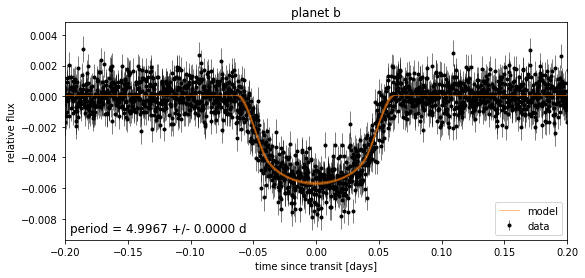

In [205]:
for n, letter in enumerate("b"):
    plt.figure(figsize=(9,4))

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y, yerr=yerr, fmt=".k", lw=.5, label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.percentile(pred, [3, 50, 97], axis=0)
    
    art = plt.fill_between(
    x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")
    plt.plot(x_fold[inds], pred[1], color="C1", label="model", lw=.5)

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.2, 0.2)
    plt.show()

## Citations

As described in the [Citing exoplanet & its dependencies](./citation.ipynb) tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [185]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

print("\n".join(bib.splitlines()[:10]) + "\n...")

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol20, exoplanet:arviz, exoplanet:astropy13,
exoplanet:astropy18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.

@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Arjun Savel and Rodrigo Luger and
            Ian Czekala and Eric Agol and Adrian Price-Whelan and
            Christina Hedges and Emily Gilbert and Tom Barclay and Luke Bouma
            and Timothy D. Brandt},
   title = {exoplanet-dev/exoplanet v0.4.5},
   month = mar,
    year = 2021,
     doi = {10.5281/zenodo.1998447},
...
